## 1. Introduction

### 1.1 Objectives
- Conduct sentiment analysis on text data collected from various platforms such as Facebook, Twitter, and more using advanced natural language processing (NLP) techniques.
- Train machine learning models to classify texts as positive, negative, or neutral.
- Provide insights into public opinion trends to help organizations understand and respond to customer sentiments across different platforms.

### 1.2 Estimated Effects
- By understanding sentiment trends, businesses can tailor their communication strategies to better engage with their audience.
- Insights into public opinion can help marketers create more targeted and effective campaigns.

### 1.3 Data Explanation
- This dataset is sourced from Kaggle datasets and can be accessed [here](https://www.kaggle.com/datasets/jp797498e/twitter-entity-sentiment-analysis).
- Data Source: The dataset comprises texts collected from platforms like Facebook and Twitter.

## 2. Data Preprocessing

#### Import Necessary Libraries

In [14]:
# Enginerring and EDA
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns


# Data Preprocessing
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
import emoji
import re
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import  TfidfVectorizer


# Sentiment Analysis and model analysis
import nltk
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.feature_selection import SelectKBest
from textblob import TextBlob
from wordcloud import WordCloud
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB


# NLTK downloads
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt to /Users/kim-yunso/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/kim-
[nltk_data]     yunso/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/kim-
[nltk_data]     yunso/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/kim-
[nltk_data]     yunso/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /Users/kim-
[nltk_data]     yunso/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

### 2.1 Load and Check the Dataset

In [17]:
train_df = pd.read_csv('./Dataset/twitter_training.csv', header=None)
test_df = pd.read_csv('./Dataset/twitter_validation.csv', header=None)

In [19]:
train_df.head()

,0,1,2,3
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [21]:
test_df.head()

,0,1,2,3
0,3364,Facebook,Irrelevant,I mentioned on Facebook that I was struggling ...
1,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
2,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
3,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
4,4433,Google,Neutral,Now the President is slapping Americans in the...


In [23]:
# Add column names

train_df.columns = ['user_id', 'platform', 'sentiment', 'text']
test_df.columns = ['user_id', 'platform', 'sentiment', 'text']

In [25]:
# Identify target column
target_col = 'sentiment'

In [27]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74682 entries, 0 to 74681
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   user_id    74682 non-null  int64 
 1   platform   74682 non-null  object
 2   sentiment  74682 non-null  object
 3   text       73996 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB


In [29]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   user_id    1000 non-null   int64 
 1   platform   1000 non-null   object
 2   sentiment  1000 non-null   object
 3   text       1000 non-null   object
dtypes: int64(1), object(3)
memory usage: 31.4+ KB


### 2.2 Data Preprocessing

#### Check and remove NA values

In [33]:
train_df.isnull().sum()

user_id        0
platform       0
sentiment      0
text         686
dtype: int64

In [35]:
train_df.dropna(inplace=True, axis=0)

#### Prprocess the texts

In [38]:
def process_text(text):
    # Convert emojis to text descriptions
    text = emoji.demojize(text)

    # Lowercase text
    text = text.lower()

    # Remove numbers
    text = re.sub(r'\d+', '', text)
    
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)

    # Tokenize the text
    tokens = word_tokenize(text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words and token.isalpha()]

    # Remove extra spaces
    tokens = [token.strip() for token in tokens]

    # Initialize Lemmatizer and Stemmer
    lemmatizer = WordNetLemmatizer()
    stemmer = PorterStemmer()

    # Stemming
    tokens_stemmed = [stemmer.stem(token) for token in tokens]
    
    # Lemmatize the tokens
    lemmatized_tokens = [lemmatizer.lemmatize(token_stemmed) for token_stemmed in tokens_stemmed]
        
    return lemmatized_tokens

In [40]:
train_df['processed_text'] = train_df['text'].apply(process_text)
test_df['processed_text'] = test_df['text'].apply(process_text)

train_df['joined_text'] = train_df['processed_text'].apply(lambda x: ' '.join(x))
test_df['joined_text'] = test_df['processed_text'].apply(lambda x: ' '.join(x))

In [41]:
train_df.head()

,user_id,platform,sentiment,text,processed_text,joined_text
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...,"[im, get, borderland, murder]",im get borderland murder
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...,"[come, border, kill]",come border kill
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...,"[im, get, borderland, kill]",im get borderland kill
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...,"[im, come, borderland, murder]",im come borderland murder
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...,"[im, get, borderland, murder]",im get borderland murder


### 2.3 Interim Summary

- Removed 686 missing values from the data.
- Processed the data by:
    - Converting emojis to text
    - Converting text to lowercase
    - Removing numbers
    - Removing stop words
    - Lemmatizing and stemming words using WordNetLemmatizer and PorterStemmer

## 3. EDA and Sentiment Analysis

### 3.1 Explore the Dataset

#### Plot the distribution of platrofrms and sentiments

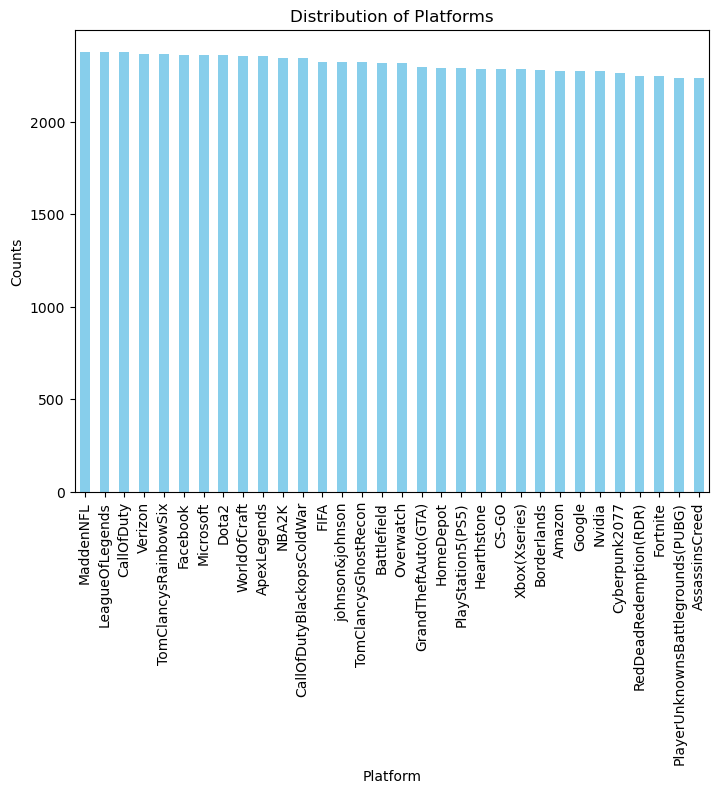

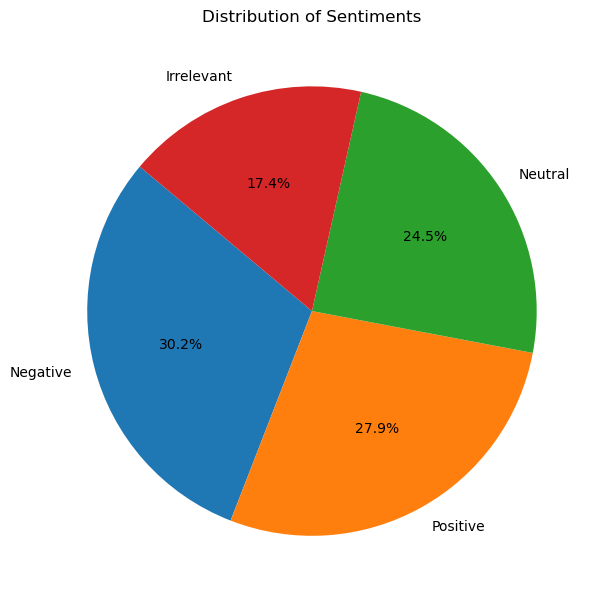

In [48]:
# Count occurrences for each platform
platform_counts = train_df['platform'].value_counts()

# Count occurrences for each sentiment
sentiment_counts = train_df['sentiment'].value_counts()

# Bar chart for platform
plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
platform_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of Platforms')
plt.xlabel('Platform')
plt.ylabel('Counts')
plt.show()


# Pie chart for sentiment
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
plt.pie(sentiment_counts, labels = sentiment_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Sentiments')

# Show the plot
plt.tight_layout()
plt.show()


#### Distribution of number of tokens

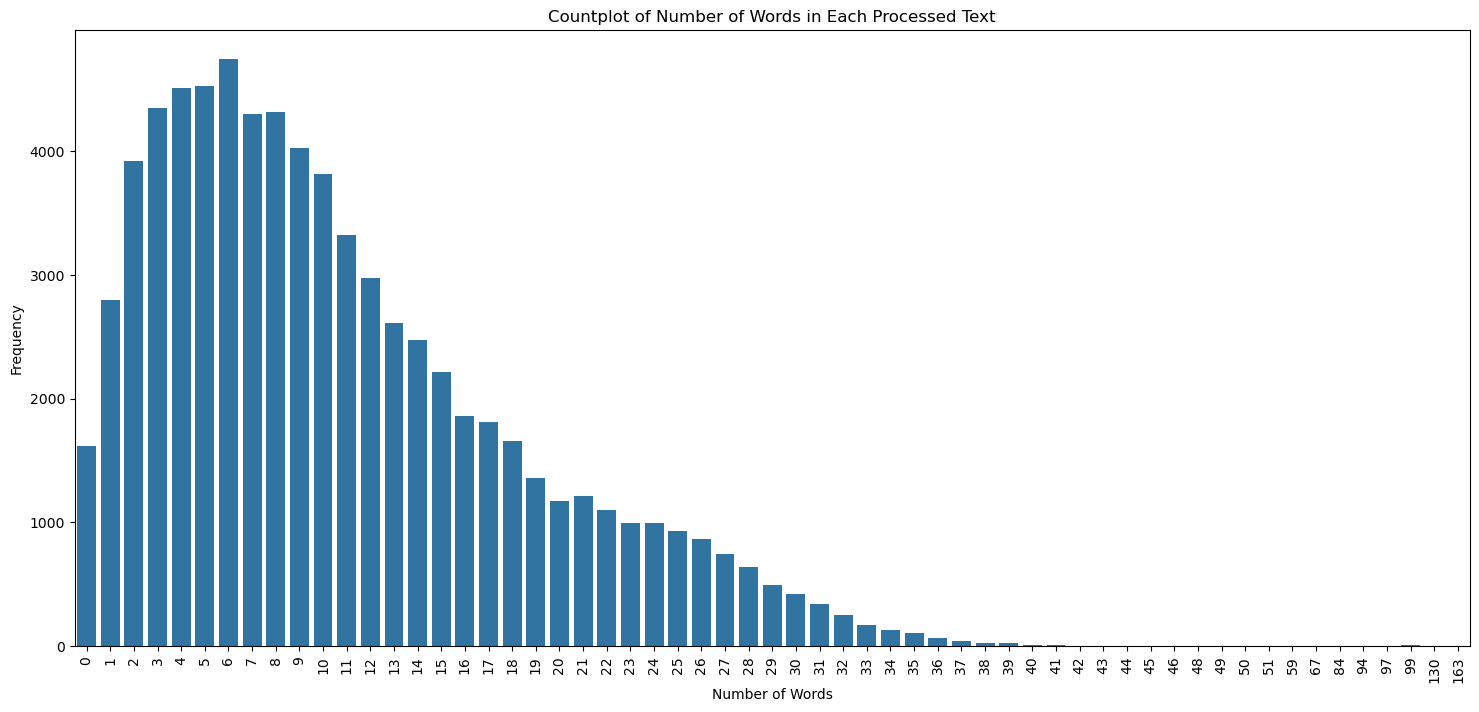

In [51]:
# Calculate the number of words for each text
train_df['word_count'] = train_df['processed_text'].apply(len)

# Plotting
plt.figure(figsize=(18, 8))
sns.countplot(x='word_count', data=train_df)
plt.title('Countplot of Number of Words in Each Processed Text')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.xticks(rotation = 90)
plt.show()

In [53]:
# Drop rows with more than 40 words

train_df = train_df[train_df['processed_text'].apply(len) <= 40]

### 3.2 Sentiment Analysis

#### Distribution of polarity score

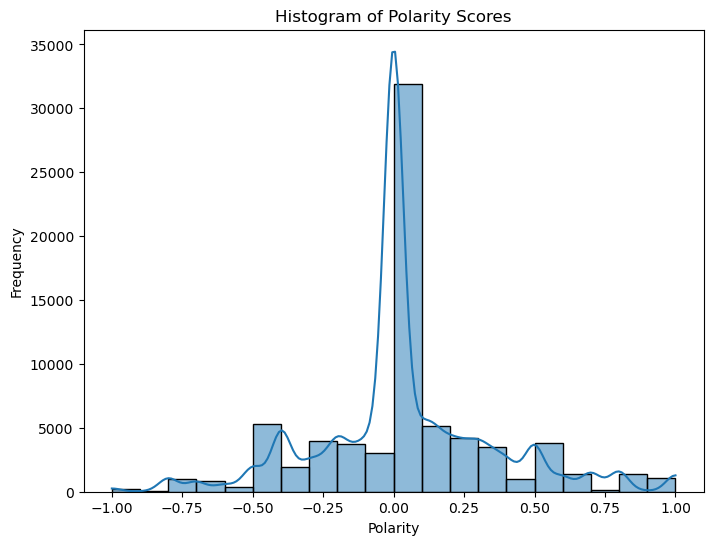

In [57]:
train_df["polarity"] = train_df["joined_text"].map(lambda Text: TextBlob(Text).sentiment.polarity)

plt.figure(figsize=(8, 6))
sns.histplot(train_df['polarity'], bins=20, kde=True)
plt.title('Histogram of Polarity Scores')
plt.xlabel('Polarity')
plt.ylabel('Frequency')
plt.show()

#### Word Cloud of each sentiment (Positive, Neurtral, Negative, Irrelevant)

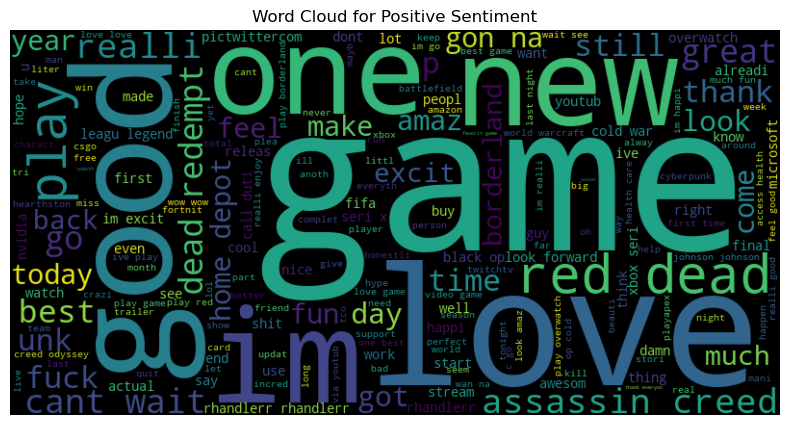

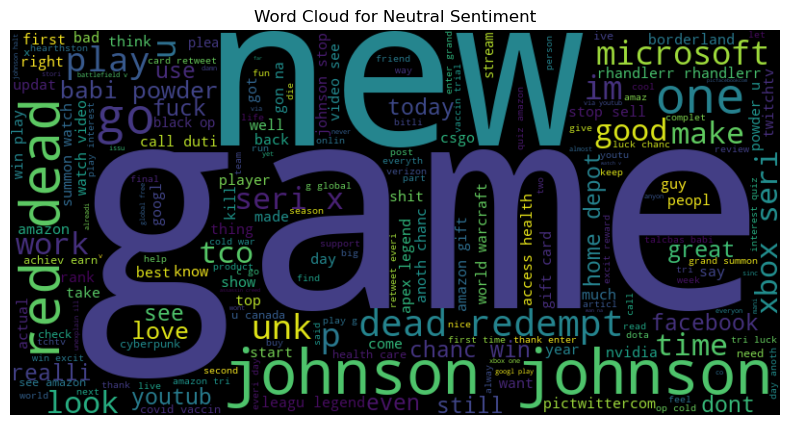

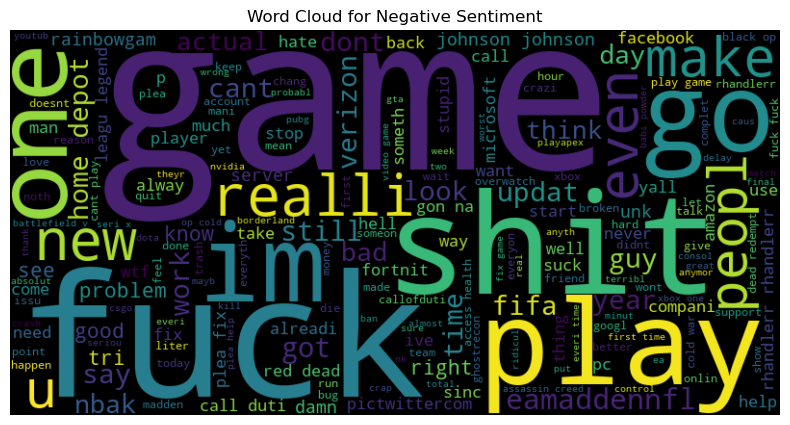

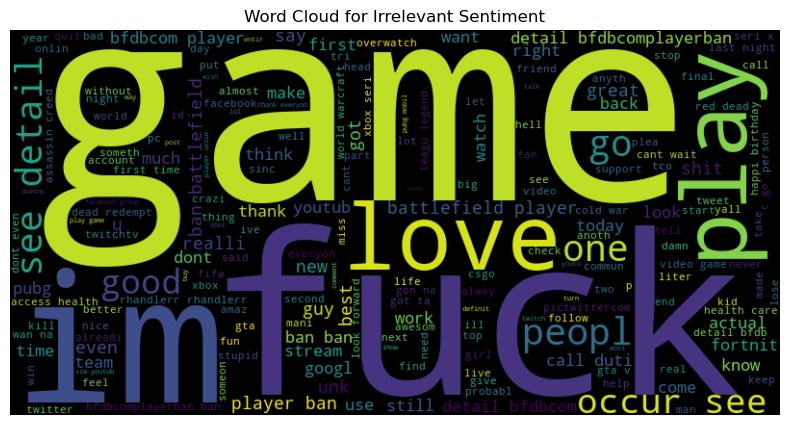

In [60]:
def create_word_cloud(text, sentiment):
    wordcloud = WordCloud(width=800, height=400, background_color='black').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for {sentiment.capitalize()} Sentiment')
    plt.show()
    print()

# Generate text for each sentiment
for sentiment in ['Positive', 'Neutral','Negative', 'Irrelevant']:
    text = ' '.join([' '.join(tokens) for tokens in train_df[train_df['sentiment'] == sentiment]['processed_text']])
    if text:  # Check if there is any text for the sentiment
        create_word_cloud(text, sentiment)

#### Sentiment Analysis using VADER

In [65]:
sia = SentimentIntensityAnalyzer()

In [67]:
res = {}
for i, row in tqdm(train_df.iterrows(), total=len(train_df)):
    text = row['text']
    myid = row['user_id']
    res[myid] = sia.polarity_scores(text)

  0%|          | 0/73956 [00:00<?, ?it/s]

In [69]:
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={'index': 'user_id'})
train_df = vaders.merge(train_df, how='left')

train_df.head(3)

,user_id,neg,neu,pos,compound,platform,sentiment,text,processed_text,joined_text,word_count,polarity
0,2401,0.37,0.63,0.0,-0.6908,Borderlands,Positive,im getting on borderlands and i will murder yo...,"[im, get, borderland, murder]",im get borderland murder,4,0.0
1,2401,0.37,0.63,0.0,-0.6908,Borderlands,Positive,I am coming to the borders and I will kill you...,"[come, border, kill]",come border kill,3,0.0
2,2401,0.37,0.63,0.0,-0.6908,Borderlands,Positive,im getting on borderlands and i will kill you ...,"[im, get, borderland, kill]",im get borderland kill,4,0.0


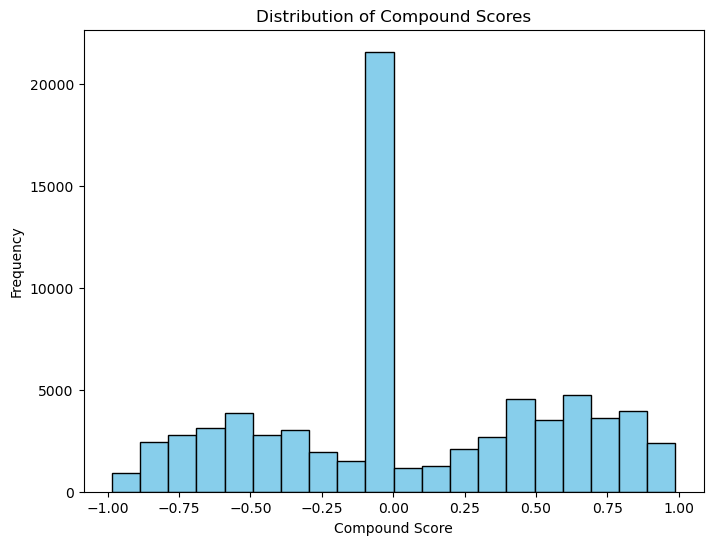

In [71]:
plt.figure(figsize=(8, 6))
plt.hist(train_df['compound'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Compound Scores')
plt.xlabel('Compound Score')
plt.ylabel('Frequency')
plt.show()

#### Most Positive and Negative platforms

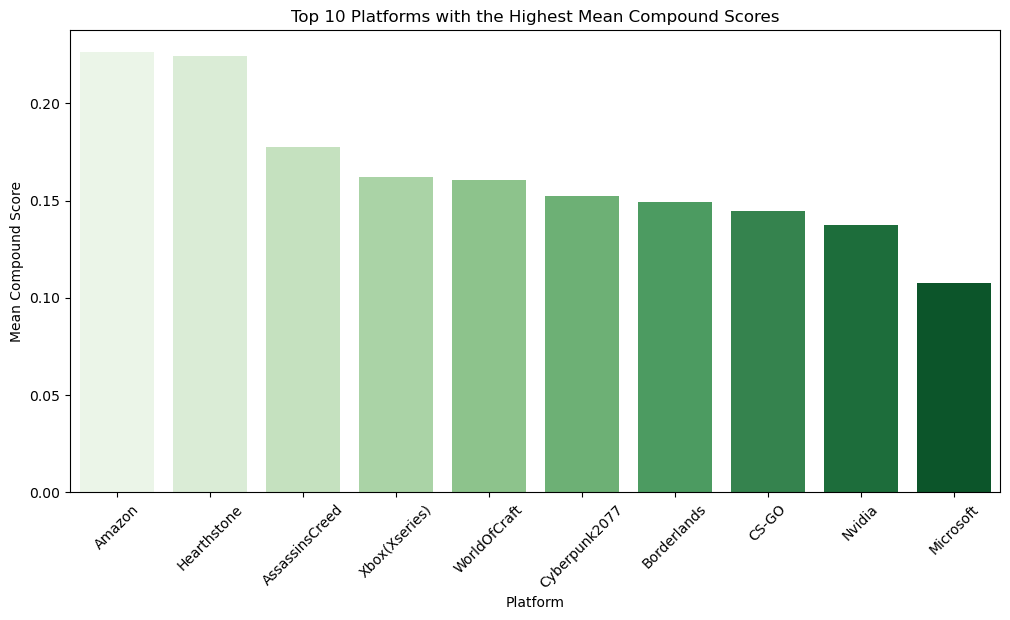

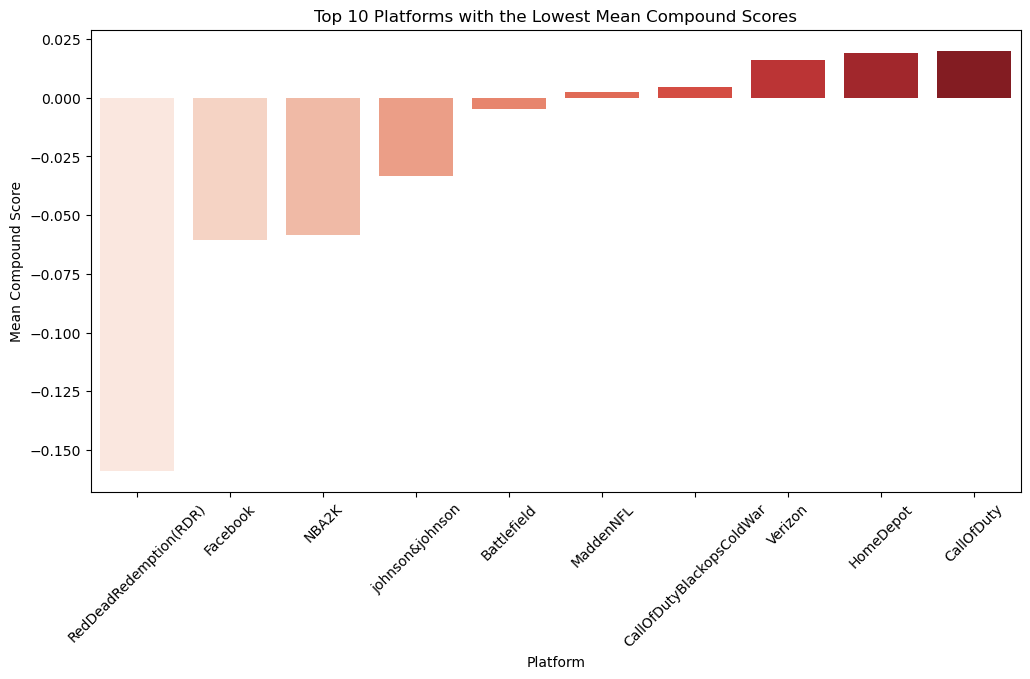

In [77]:
# Plot top positive platforms
plt.figure(figsize=(12, 6))
sns.barplot(x=top_positive_platforms.index, y=top_positive_platforms.values, hue=top_positive_platforms.index, palette='Greens', dodge=False, legend=False)
plt.title('Top 10 Platforms with the Highest Mean Compound Scores')
plt.xlabel('Platform')
plt.ylabel('Mean Compound Score')
plt.xticks(rotation=45)
plt.show()

# Plot top negative platforms
plt.figure(figsize=(12, 6))
sns.barplot(x=top_negative_platforms.index, y=top_negative_platforms.values, hue=top_negative_platforms.index, palette='Reds', dodge=False, legend=False)
plt.title('Top 10 Platforms with the Lowest Mean Compound Scores')
plt.xlabel('Platform')
plt.ylabel('Mean Compound Score')
plt.xticks(rotation=45)
plt.show()

#### Most Postiive and Negative Sentneces

In [79]:
most_positive = train_df.loc[train_df['compound'].idxmax()]

# Find the most negative sentence
most_negative = train_df.loc[train_df['compound'].idxmin()]

print("Most Positive Sentence:")
print(most_positive['text'])

print()

print("\nMost Negative Sentence:")
print(most_negative['text'])

Most Positive Sentence:
 . I played this interesting Quiz on Amazon-Play games at Amazon FunZone . It's very easy to play try your luck for exciting rewards. Please download the Amazon app from Google Play Store amazon.in/game/share/gL9…. I am eligible for win prize.....


Most Negative Sentence:
Welp there it is no Ps5 for me damn Fuck u @Walmart All your Fucking fault for dropping it earlier Fucking shit ass fucking crack head ass company fuck you


### 3.3 Interim Summary
- The number of tweets across platforms is similar
- Negative tweets have the highest frequency, though the difference from other sentiments isn't significant.
- Tokens range from 0 to 163, but those over 40 were removed since most are under 40.
- Neutral tweets are more common than positive and negative ones based on polarity scores.
- The word cloud reveals key sentiment words:
    - Positive: "Good," "Love," "New"
    - Negative: "Johnson," "New," "Red"
    - Negative: "Fuck," "Shit," "Play"
    - Irrelevant: "Fuck," "Love," "Play"
- Top 3 platforms with the most positive tweets: Amazon, Hearthstone, AssassinsCreed.
- Top 3 platforms with the most negative tweets: RedDeadRedemption, Facebook, NBA2K.

## 4. Feature Engineering

### 4.1 Encoding of target column and Vectorization of tokens using TF-IDF

#### Encoding of target column

In [83]:
label_encoder = LabelEncoder()

# Use .loc to avoid SettingWithCopyWarning
train_df.loc[:, target_col] = label_encoder.fit_transform(train_df[target_col])
test_df.loc[:, target_col] = label_encoder.transform(test_df[target_col])

# Print the mapping
for index, label in enumerate(label_encoder.classes_):
    print(f'{label}: {index}')

Irrelevant: 0
Negative: 1
Neutral: 2
Positive: 3


#### Vectorization of tokens using TF-IDF

In [86]:
tfidf_vectorizer = TfidfVectorizer(min_df=5,
                        ngram_range=(1, 2), 
                        stop_words='english')

In [88]:
X_train_tfidf = tfidf_vectorizer.fit_transform(train_df['joined_text'])
X_test_tfidf = tfidf_vectorizer.transform(test_df['joined_text'])

y_train = train_df[target_col].astype(int)
y_test = test_df[target_col].astype(int)

### 4.2 Interim Summary

- Encoded the target column using a label encoder.
- Vectorized the tokens with a TF-IDF vectorizer.

## 5. Model Analysis

### 5.1 Base Model Training 

In [93]:
# Define models
models = {
    'Logistic Regression': LogisticRegression(max_iter = 1000),
    'Random Forest': RandomForestClassifier(),
    'Naive Bayes': MultinomialNB()
}

# Train and evaluate models
for model_name, model in models.items():
    model.fit(X_train_tfidf, y_train)
    y_pred = model.predict(X_test_tfidf)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    print(f'{model_name} Results:')
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print('-' * 30)

Logistic Regression Results:
Accuracy: 0.9480
Precision: 0.9481
Recall: 0.9480
F1 Score: 0.9480
------------------------------
Random Forest Results:
Accuracy: 0.9650
Precision: 0.9651
Recall: 0.9650
F1 Score: 0.9650
------------------------------
Naive Bayes Results:
Accuracy: 0.8910
Precision: 0.8986
Recall: 0.8910
F1 Score: 0.8913
------------------------------


Select Features based on importance

### 5.2 Model Training with Feature Selection

#### Select features by feature importance in logistic regression

In [98]:
model = LogisticRegression(max_iter = 1000)
model.fit(X_train_tfidf, y_train)

LogisticRegression(max_iter=1000)

In [100]:
feature_names = tfidf_vectorizer.get_feature_names_out()
importance = np.abs(model.coef_[0])


sorted_indices = np.argsort(np.abs(importance))[-6000:]
important_features = feature_names[sorted_indices]
important_importance = importance[sorted_indices]

# Filter the train and test sets to have only these features
X_train_selected = X_train_tfidf[:, sorted_indices]
X_test_selected = X_test_tfidf[:, sorted_indices]

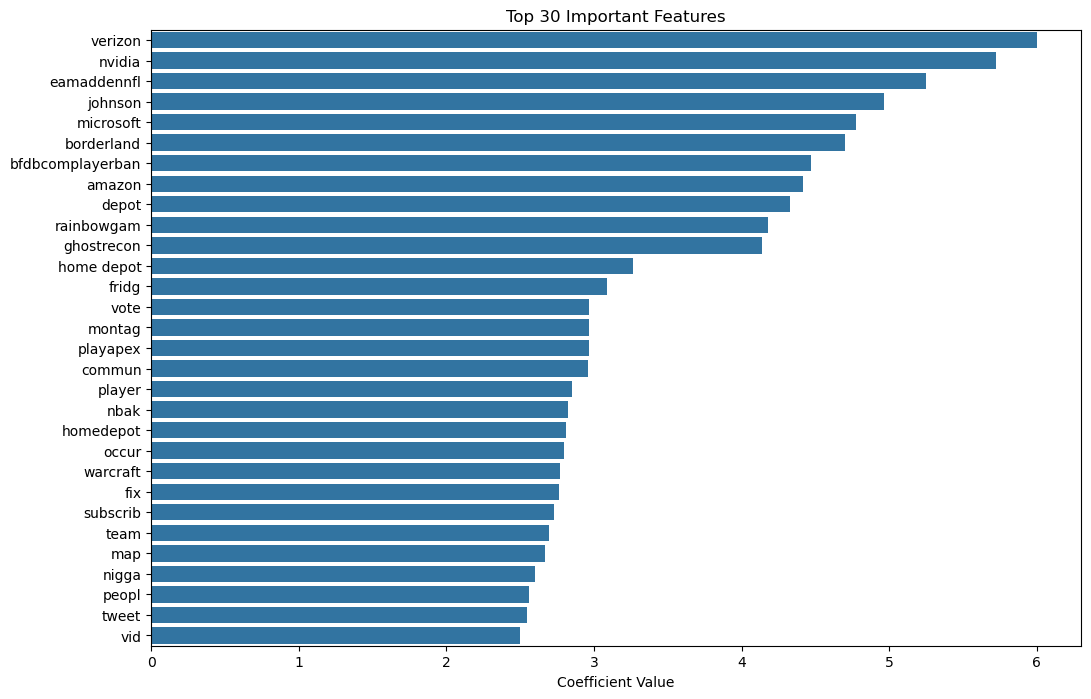

In [102]:
# Sort and select the top 30 features for plotting
top_indices = np.argsort(np.abs(important_importance))[-30:][::-1]
top_features = important_features[top_indices]
top_importance = important_importance[top_indices]

# Plot the feature importance
plt.figure(figsize=(12, 8))
sns.barplot(x=top_importance, y=top_features)
plt.xlabel("Coefficient Value")
plt.title("Top 30 Important Features")
plt.show()

#### Model Training with selected features

In [107]:
# Define models
models = {
    'Logistic Regression': LogisticRegression(max_iter = 1000),
    'Random Forest': RandomForestClassifier(),
    'Naive Bayes': MultinomialNB()
}

# Train and evaluate models
for model_name, model in models.items():
    model.fit(X_train_selected, y_train)
    y_pred = model.predict(X_test_selected)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    print(f'{model_name} Results:')
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print('-' * 30)

Logistic Regression Results:
Accuracy: 0.7320
Precision: 0.7370
Recall: 0.7320
F1 Score: 0.7304
------------------------------
Random Forest Results:
Accuracy: 0.9330
Precision: 0.9366
Recall: 0.9330
F1 Score: 0.9336
------------------------------
Naive Bayes Results:
Accuracy: 0.6590
Precision: 0.7031
Recall: 0.6590
F1 Score: 0.6572
------------------------------


### 5.3 Interim Summary

- Random Forest showed the highest performance.
- Top 3 important features: "verizon," "nvidia," "eamaddennfl."
- Training with selected features caused a significant performance decrease, especially for Logistic Regression and Naive Bayes.

## 6. Findings, Recommendations, Limitations

**Key Findings**

- Sentiment analysis across platforms shows similar tweet numbers.
- Negative sentiment is most frequent, but differences between sentiments are minor.
- Neutral tweets are more common based on polarity scores.
- Random Forest performed best, highlighting key features: "verizon," "nvidia," "eamaddennfl."
 
**Recommendations**

- Use sentiment insights to refine communication strategies and enhance audience engagement.
- Leverage positive and negative sentiment trends to create targeted marketing campaigns.
Limitations

**Limitations**

- Difficulty training models like SVC due to computational constraints.
- Potential bias in the dataset, as it may not represent all demographics equally.
- Using only important features led to reduced performance, indicating a need for alternative feature selection methods.
